In [855]:
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from scipy.stats import norm, skew
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Conjuntos de dados

In [856]:
df_train = pd.read_csv("data/train.csv",sep=',')
df_test = pd.read_csv("data/test.csv",sep=',')
test_ids = df_test['Id']
df_test['preco'] = None
train_size = len(df)
df_train.head(3)

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0


Além do conjunto de treino fornecido no desafio, será utilizado também um conjunto de informações complemetares, disponibilizadas publicamente pelo governo de Pernambuco no site do [Banco de dados do Estado](http://www.bde.pe.gov.br/visualizacao/Visualizacao_formato2.aspx?CodInformacao=1162&Cod=3).Essas informações são referentes a distribuição de renda média dentro de cada um dos bairros da cidade de recife e foram coletados no ano de 2010.

In [857]:
neighborhood_income = pd.read_csv("data/renda_bairros.csv",sep=',')
neighborhood_income.iloc[:,2:] = neighborhood_income.iloc[:,1:].fillna(0)
neighborhood_income.iloc[:, 2:] = neighborhood_income.iloc[:, 2:].divide(neighborhood_income.iloc[:,1], axis = 'rows')
neighborhood_income = neighborhood_income.drop(columns=['Total ¹'])
neighborhood_income.head(3)

,bairro,Até 1/2 salário mínimo,Mais de 1/2 a 1 salário mínimo,Mais de 1 a 2 salários mínimos,Mais de 2 a 5 salários mínimos,Mais de 5 a 10 salários mínimos,Mais de 10 a 20 salários mínimos,Mais de 20 salários mínimos,Sem rendimento
0,Aflitos,0.002581,0.012390,0.026846,0.094476,0.223542,0.308725,0.273619,0.057821
1,Afogados,0.036308,0.194274,0.253974,0.301842,0.114884,0.033779,0.006954,0.057984
2,Agua Fria,0.055393,0.219538,0.296974,0.285993,0.070360,0.013584,0.002603,0.055556


## Pré processamento dos dados

### Remoção de outliers

O conjunto de dados possui 3 variáveis contínuas com grande variância, são elas: preço do imóvel, área útil e área extra. Através da plotagem do boxplot é possível verificar que existem outliers em todas essas variáveis, o que pode atraplhar de maneira significativa o desempenho de regressão.

Sendo assim, a primeira etapa de pré processamente dos dados foi a remoção das linhas em que umas dessas três variáveis é outlier.

4531 linhas no dataset


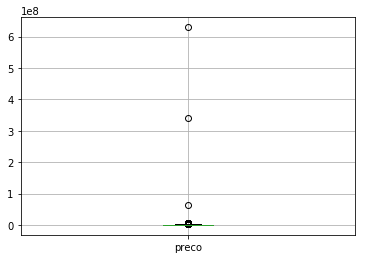

In [858]:
df_train.boxplot(column = ['preco'])
original_size = len(df_train)
print("{} linhas no dataset".format(train_size))

4531 linhas no dataset
Diminuição de 3.25% no tamanho do conjunto de treino


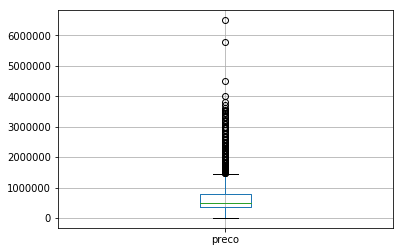

In [859]:
columns = ['preco','area_extra','area_util']
for column in columns:
    df_train = df_train[np.abs(df_train[column] - df_train[column].mean()) <= (2 * df_train[column].std())]

df_train.boxplot(column = ['preco'])

print("{} linhas no dataset".format(len(df_train['preco'])))
redu = round(((original_size - len(df_train))/original_size)* 100,2)
print("Diminuição de {}% no tamanho do conjunto de treino".format(redu))

Unificaremos os dados de treino e testes para aplicar as transformações necessárias e tornaremos a separar esses dados antes de realizar o treinamento dos modelos.

In [860]:
train_size = len(df_train)
df = pd.concat((df_train, df_test))

### Agregação de dados de distribuição de renda

Como forma de enriquecer o conjunto de treino, adicionamos 8 novas colunas referentes a distribuição de renda nos bairros. Alguns dos bairros presentes no conjunto de treino não são de fato bairros da cidade de Recife, mas sim pontos de referência. Nesses casos preencheremos essas linhas com uma distribuição uniforme de renda.

Após realizar esse procedimento a coluna categória ¨bairro¨ será removida do conjunto de dados.

In [861]:
income_columns = ['meio_salario','meio_1_salario','1_2_salarios','2_5_salarios','5_10_salarios','10_20_salarios','20_salarios','sem_salario']
df = pd.concat([df, df.reindex(columns = income_columns)], axis = 1)

all_neighborhood = list(df.bairro.unique())

skip_neighborhood = ['Beira Rio', 'Centro']
neighborhood = list(set(all_neighborhood).symmetric_difference(skip_neighborhood))

df.loc[df.bairro == 'Beira Rio', woth_column_names] = 1/len(woth_column_names)
df.loc[df.bairro == 'Centro', woth_column_names] = 1/len(woth_column_names)


for neighborhood_name in neighborhood:
        df.loc[df.bairro == neighborhood_name, woth_column_names] = neighborhood_income[neighborhood_income['bairro'] == neighborhood_name].iloc[:,1:].values

df = df.drop(columns=['bairro'])
df.head(3)

,Id,tipo,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,churrasqueira,...,vista_mar,preco,meio_salario,meio_1_salario,1_2_salarios,2_5_salarios,5_10_salarios,10_20_salarios,20_salarios,sem_salario
0,2000,Casa,Imobiliaria,3,3,5,223,167,piscina e copa,0,...,0,1e+06,0.041486,0.165743,0.224197,0.281916,0.154787,0.073218,0.017770,0.040884
1,2001,Apartamento,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,1,...,0,680000,0.012156,0.101979,0.141028,0.269471,0.188038,0.153292,0.101764,0.032272
2,2002,Apartamento,Imobiliaria,3,1,0,53,0,nenhum,0,...,0,450000,0.003992,0.036427,0.066617,0.208084,0.285180,0.239521,0.147455,0.012725


### Discretização de variáveis

Aplicaremos a técnica de **one hot encoding** para binarizar as seguintes informações: tipo do imóvel, número de quartos e número de vagas na garagem. 

Além disso serão removidas as colunas *Id, tipo do vendedor e diferencial*. A coluna *¨Id¨* não agrega nenhuma informação aos dados, sendo apenas um identificador. As informações da coluna *¨diferencial¨* já estão contidas em outras colunas binárias. Por fim, a coluna *´tipo´* agrega poucas informação uma vez que mais de 95% dos dados estão preenchidos com o valor *¨imobiliária¨*.


In [862]:
# discrete_numeric_columns = ['quartos','suites','vagas']

# hot_columns = pd.get_dummies(df['tipo'], prefix= 'tipo')
# df = pd.concat([df, hot_columns], axis = 1)
# df = df.drop(columns=['tipo'])

# for column in discrete_numeric_columns:   
#     hot_columns = pd.get_dummies(df[column], prefix= column)
#     df = pd.concat([df, hot_columns], axis=1)
#     df = df.drop(columns=[column])

# df = df.drop(columns=['Id','diferenciais','tipo_vendedor'])
# df.head(3)

### Normalização dos dados

Por fim, normalizamos as colunas *¨area_util¨* e *´area_extra´* para que não tenham uma escala destoante dos demais dados. As demais colunas não precisam ser normalizas, visto que ou são binárias ou representam uma probabilidade *(valores entre 0 e 1)*.

Utilizaremos a normalização do tipo **Min-Max**.

In [863]:
from sklearn.preprocessing import minmax_scale


df[['area_util','area_extra','quartos','suites','vagas']] = minmax_scale(df[['area_util','area_extra','quartos','suites','vagas']])
df = df.drop(columns=['Id','diferenciais','tipo_vendedor','tipo'])
df.head(3)

,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,...,vista_mar,preco,meio_salario,meio_1_salario,1_2_salarios,2_5_salarios,5_10_salarios,10_20_salarios,20_salarios,sem_salario
0,0.222222,0.500000,0.166667,0.076131,0.013847,0,0,1,0,0,...,0,1e+06,0.041486,0.165743,0.224197,0.281916,0.154787,0.073218,0.017770,0.040884
1,0.333333,0.666667,0.066667,0.051857,0.000000,1,0,1,0,0,...,0,680000,0.012156,0.101979,0.141028,0.269471,0.188038,0.153292,0.101764,0.032272
2,0.222222,0.166667,0.000000,0.013608,0.000000,0,0,0,0,0,...,0,450000,0.003992,0.036427,0.066617,0.208084,0.285180,0.239521,0.147455,0.012725


In [876]:
df_test = df.iloc[train_size:,:]
df_test = df_test.drop(columns=['preco'])
df = df.iloc[:train_size,:]
df = df.convert_objects(convert_numeric=True)

In [877]:
print(len(df_test.columns))
print(len(df.columns))

23
24


## Transformação da variável algo para distribuição normal

Os preços de imóveis tendem a ter uma distribuição de cauda pesada, o que não é o mais adequado para a aplicação de modelos de regressão. Aplicaremos a transformação **log1p** do scikit learn para aproximar essa distribuição de uma normal e assim melhorar eficiência dos modelos de regressão.

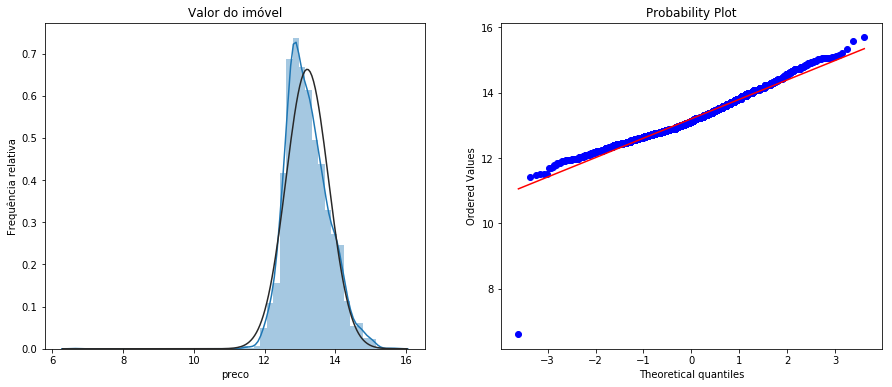

In [878]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(df['preco'], fit = norm, ax = axes[0]);
(mu, sigma) = norm.fit(df['preco'])

axes[0].set_ylabel('Frequência relativa')
axes[0].set_title('Valor do imóvel')


stats.probplot(df['preco'], plot = axes[1])
plt.show()

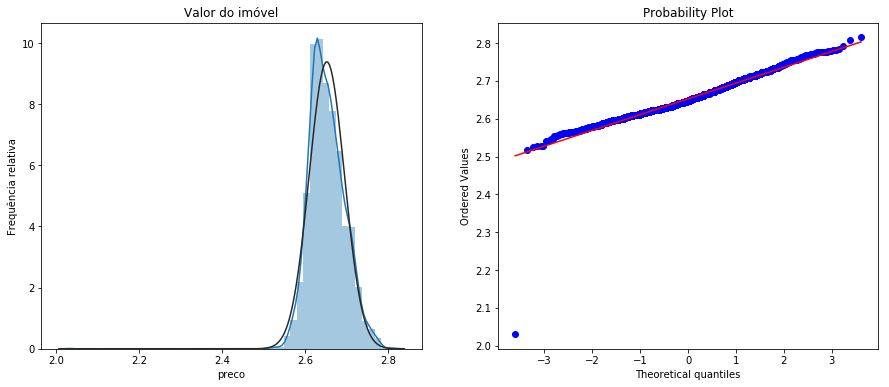

In [879]:
df['preco'] = np.log1p(df['preco'])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(df['preco'], fit = norm, ax = axes[0]);
(mu, sigma) = norm.fit(df_with_income['preco'])

axes[0].set_ylabel('Frequência relativa')
axes[0].set_title('Valor do imóvel')


stats.probplot(df['preco'], plot = axes[1])
plt.show()

Variáveis a serem usadas nos modelos

In [869]:
target = df['preco']
parameters = df.copy().drop(columns=['preco'])

In [880]:
parameters.columns

Index(['quartos', 'suites', 'vagas', 'area_util', 'area_extra',
       'churrasqueira', 'estacionamento', 'piscina', 'playground', 'quadra',
       's_festas', 's_jogos', 's_ginastica', 'sauna', 'vista_mar',
       'meio_salario', 'meio_1_salario', '1_2_salarios', '2_5_salarios',
       '5_10_salarios', '10_20_salarios', '20_salarios', 'sem_salario'],
      dtype='object')

## Modelos

In [871]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import lightgbm as lgb

### Validação dos modelos

Para a validação dos modelos treinados será utilizada a técnica de validação cruzada. A cada modelo serão feitas 5 execuções com validação cruzada e calculada a média dos resultados. A métrica de erro utilizada, como sugerido no desafio, será o RMSPE.

In [846]:
## cross validation executions numbers

cv_number = 5

## RMSPE function

def rmspe(y_pred, y):
    rmspe = np.sqrt(np.mean( (1/ y**2) * (y_pred - y)**2 ))
    return rmspe

rmspe_score = make_scorer(rmspe, greater_is_better=False)

## Dataset to store results

results = pd.DataFrame([], columns = ['mean', 'std'])

In [847]:
polynomial = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear',linear_model.LinearRegression(fit_intercept = False))]) 

scores = cross_val_score(ridge,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = 2)

results.loc['Polynomial'] = [-scores.mean(), scores.std()]

### Ridge Regression

Melhor resultado obtido com alpha = 0.3370270270270271, resultado obtido: 0.020527167043658777


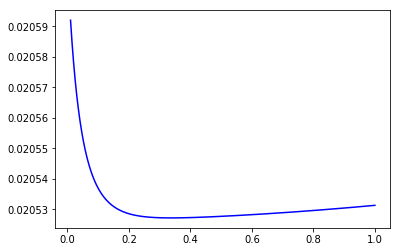

In [716]:
ridge_alpha_tunning = []

domain = list(np.linspace(0.01,1,1000))
for alpha_value in domain:    
    ridge = linear_model.Ridge(alpha = alpha_value, max_iter = 1000, random_state = 161095)
    scores = cross_val_score(ridge,
                             parameters,
                             target,
                             scoring = rmspe_score,
                             cv = cv_number)
    ridge_alpha_tunning.append(-np.mean(scores))


while max(ridge_alpha_tunning) > 1:
        index  = ridge_alpha_tunning.index(max(ridge_alpha_tunning))
        del domain[index]
        del ridge_alpha_tunning[index]
        
best_alpha = domain[ridge_alpha_tunning.index(min(ridge_alpha_tunning))]
ridge = linear_model.Ridge(alpha = best_alpha, max_iter = 1000, random_state = 161095)
scores = cross_val_score(ridge,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['Ridge'] = [-scores.mean(), scores.std()]

print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(best_alpha, min(ridge_alpha_tunning)))

plt.plot(domain, ridge_alpha_tunning, color='b')

### Lasso regression

In [717]:
lasso_alpha_tunning = []
domain = list(np.linspace(0.001,1,500))
for alpha_value in domain:    
    lasso = linear_model.Lasso(alpha = alpha_value,random_state = 161095)
    scores = cross_val_score(lasso,
                             paramaters_ninfo_n,
                             target_ninfo_n,
                             scoring = rmspe_score,
                             cv = cv_number)
    lasso_alpha_tunning.append(-np.mean(scores))


while max(lasso_alpha_tunning) > 1:
        index  = lasso_alpha_tunning.index(max(lasso_alpha_tunning))
        del domain[index]
        del lasso_alpha_tunning[index]
        
best_alpha = domain[lasso_alpha_tunning.index(min(lasso_alpha_tunning))]
lasso = linear_model.Lasso(alpha = alpha_value,random_state = 161095, max_iter = 3000)
scores = cross_val_score(lasso,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['Lasoo'] = [-scores.mean(), scores.std()]

print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(domain[lasso_alpha_tunning.index(min(lasso_alpha_tunning))],min(lasso_alpha_tunning)))
plt.plot(domain, lasso_alpha_tunning, color='b')

KeyboardInterrupt: 

### Elastic Net

In [759]:
elastic_alpha_tunning = []
domain = list(np.linspace(0.001,1,500))
for alpha_value in domain:    
    elastic_net = ElasticNet(alpha = alpha_value, l1_ratio= 0.6, copy_X = True,random_state = 161095)
    scores = cross_val_score(elastic_net,
                             paramaters_ninfo_n,
                             target_ninfo_n,
                             scoring = rmspe_score,
                             cv = cv_number)
    elastic_alpha_tunning.append(-np.mean(scores))


while max(elastic_alpha_tunning) > 1:
        index  = elastic_alpha_tunning.index(max(elastic_alpha_tunning))
        del domain[index]
        del elastic_alpha_tunning[index]
        
best_alpha = domain[elastic_alpha_tunning.index(min(elastic_alpha_tunning))]
elastic_net = ElasticNet(alpha = alpha_value, l1_ratio= 0.6, copy_X = True,random_state = 161095)
scores = cross_val_score(elastic_net,
                         parameters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['ElasticNet'] = [-scores.mean(), scores.std()]
        
print("Melhor resultado obtido com alpha = {}, resultado obtido: {}".format(domain[elastic_alpha_tunning.index(min(elastic_alpha_tunning))],min(elastic_alpha_tunning)))
plt.plot(domain, elastic_alpha_tunning, color='b')

KeyboardInterrupt: 

### Bayesian Ridge

In [776]:
from sklearn.linear_model import BayesianRidge
bayesian_ridge = BayesianRidge()

scores = cross_val_score(bayesian_ridge,
                         paramaters_ninfo_n,
                         target_ninfo_n,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['BayesianRidge'] = [-scores.mean(), scores.std()]

### Random Forest

In [777]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 100)

scores = cross_val_score(random_forest,
                         paramaters_ninfo_n,
                         target_ninfo_n,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['RandomForest'] = [-scores.mean(), scores.std()]

### LGBoost

In [849]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate = 0.1, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 3, min_sum_hessian_in_leaf = 5)

scores = cross_val_score(lgbm,
                         paramaters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['LGBM'] = [-scores.mean(), scores.std()]

### KNN

In [779]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

scores = cross_val_score(knn,
                         paramaters,
                         target,
                         scoring = rmspe_score,
                         cv = cv_number)

results.loc['KNeighbors'] = [-scores.mean(), scores.std()]

In [850]:
results

,mean,std
Polynomial,0.022305,0.000630
LGBM,0.018887,0.002055


## Gerando dataset de submissão

In [882]:

lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate = 0.1, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 3, min_sum_hessian_in_leaf = 5)

lgbm.fit(paramaters, target)
lgbm_predictions = lgbm.predict(df_test)
lgbm_predictions

ValueError: Number of features of the model must match the input. Model n_features_ is 52 and input n_features is 23 

In [881]:
list(set(list(df_test.columns)).symmetric_difference(list(parameters.columns)))

[]

In [883]:
len(paramaters.columns)

52